In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# reading in family info and subsetting to 65+ year olds
peeps = pd.read_csv('Data/personsx.csv')
peeps65 = peeps[peeps['AGE_P']>=65].copy()
peeps65.shape

(13389, 601)

/home/allej8/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


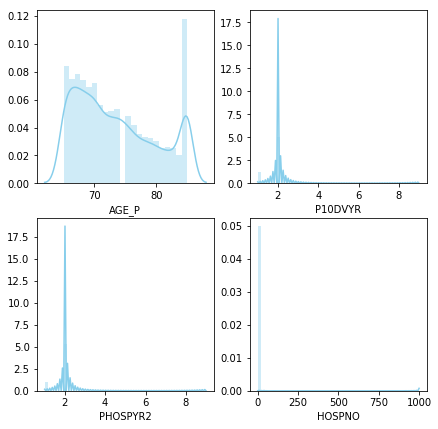

In [3]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=False)
sns.distplot(peeps65["AGE_P"] , color="skyblue", ax=axes[0, 0])
sns.distplot(peeps65["P10DVYR"] , color="skyblue", ax=axes[0, 1])
sns.distplot(peeps65["PHOSPYR2"] , color="skyblue", ax=axes[1, 0])
sns.distplot(peeps65["HOSPNO"].dropna() , color="skyblue", ax=axes[1, 1])

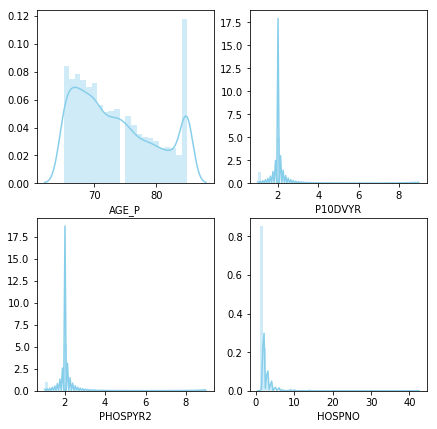

In [4]:
peeps65['HOSPNO'] = np.where(peeps65['HOSPNO'] == 999,np.nan, peeps65['HOSPNO'])

f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=False)
sns.distplot(peeps65["AGE_P"] , color="skyblue", ax=axes[0, 0])
sns.distplot(peeps65["P10DVYR"] , color="skyblue", ax=axes[0, 1])
sns.distplot(peeps65["PHOSPYR2"] , color="skyblue", ax=axes[1, 0])
sns.distplot(peeps65["HOSPNO"].dropna() , color="skyblue", ax=axes[1, 1])

In [11]:
peeps65['HOSPNO'].value_counts()

1.0     1429
2.0      369
3.0      128
4.0       57
5.0       21
6.0       16
9.0        6
7.0        5
10.0       4
14.0       2
30.0       1
42.0       1
12.0       1
8.0        1
Name: HOSPNO, dtype: int64

In [5]:
# recoding variables for easier names and to turn 7,8,9 responses to na

# 10 primary care visits in the last year.... this seems like a lot
peeps65['VISITS_10'] = np.nan
peeps65['VISITS_10'] = np.where(peeps65['P10DVYR'] == 1, 1, peeps65['VISITS_10'])
peeps65['VISITS_10'] = np.where(peeps65['P10DVYR'] == 2, 0, peeps65['VISITS_10'])

# Assuming an overnight hospital stay is an admission
peeps65['HOSPITAL_STAY'] = np.nan
peeps65['HOSPITAL_STAY'] = np.where(peeps65['PHOSPYR2'] == 1, 1, peeps65['HOSPITAL_STAY'])
peeps65['HOSPITAL_STAY'] = np.where(peeps65['PHOSPYR2'] == 2, 0, peeps65['HOSPITAL_STAY'])

peeps65['HOSPNO_CAT'] = np.nan
peeps65['HOSPNO_CAT'] = np.where(peeps65['HOSPNO'] == 1, '1', peeps65['HOSPNO_CAT'])
peeps65['HOSPNO_CAT'] = np.where(peeps65['HOSPNO'] == 2, '2', peeps65['HOSPNO_CAT'])
peeps65['HOSPNO_CAT'] = np.where(peeps65['HOSPNO'] == 3, '3', peeps65['HOSPNO_CAT'])
peeps65['HOSPNO_CAT'] = np.where(peeps65['HOSPNO'] > 3, '4 or more', peeps65['HOSPNO_CAT'])

### Are individuals who have 10 or more visits during the calendar year more likely to also have a hospital stay?
- Are they continually having problems?
- Are they abusing the healthcare system?
- Are they extremely proactive about their health?

In [6]:
cols_to_keep = ['HOSPITAL_STAY','VISITS_10', 'AGE_P']
dat = peeps65[cols_to_keep].copy().dropna()
dat.shape

(13331, 3)

In [7]:
# quick crosstab
tab = pd.crosstab(dat['VISITS_10'],dat['HOSPITAL_STAY'])
tab

HOSPITAL_STAY,0.0,1.0
VISITS_10,,
0.0,9732,1089
1.0,1558,952


[(0, 40),
 Text(0, 0.5, 'Hospitalization in last year (%)'),
 Text(0.5, 0, '>= 10 healthcare visits in last year')]

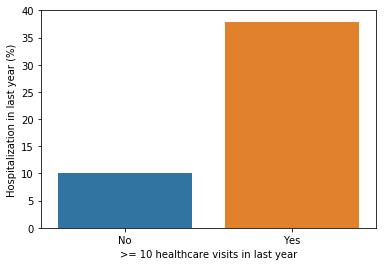

In [8]:
# Further analysis of this question regarding 10 visits and likelihood of hospital stay
tab.columns = ['NO_HOSPITALIZATION', 'HOSPITALIZATION']
pctdf = tab.reset_index().copy()
pctdf['VISITS_10'] = ['No', 'Yes']
pctdf['PERCENT'] = (pctdf['HOSPITALIZATION']/(pctdf['NO_HOSPITALIZATION'] + pctdf['HOSPITALIZATION']))*100

bp = sns.barplot(x = 'VISITS_10', y = 'PERCENT', data = pctdf)
bp.set(xlabel='>= 10 healthcare visits in last year', ylabel='Hospitalization in last year (%)', ylim=(0, 40))

In [9]:
# modeling
dat['intercept'] = 1.0
train_cols = dat.columns[1:]
train_cols
logit = sm.Logit(dat['HOSPITAL_STAY'], dat[train_cols])

# fit the model
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.386605
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          HOSPITAL_STAY   No. Observations:                13331
Model:                          Logit   Df Residuals:                    13328
Method:                           MLE   Df Model:                            2
Date:                Sun, 09 Feb 2020   Pseudo R-squ.:                 0.09683
Time:                        13:54:54   Log-Likelihood:                -5153.8
converged:                       True   LL-Null:                       -5706.4
                                        LLR p-value:                1.091e-240
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
VISITS_10      1.6721      0.052     31.926      0.000       1.569       1.775
AGE_P          0.0365      0.004      9.510      0.000       0.029       0.044
intercept     -4.8860      0.288    -16.989      0.000      -5.450      -4.322
==============================================================================
"""

### Among those with a hospitalization... are those with 10 or more visits more frequent users of the hospital?

In [ ]:
# Further analysis on this question

### Notes
- idea 1... are children more likely to have a hospitalization if their parents do? Vice versa?
- idea 2... are those who receive primary/ambulatory care 10 times or more in a year less likely to have a hospitalization
- have number of times stayed in hospital overnight -- HOSPNO
- health insurance offered at workplace, yes/no -- HIEMPOF 
- received home health care -- PHCHM2W
- number of times -- PHCHMN2W
- received advice over phone -- PHCPH2WR
- number of calls -- PHCPHN2W
- went to see provider office -- PHCDV2W
- number of office visits -- PHCDVN2W
- received care 10 times -- P10DVYR
- age -- AGE_P